# NSW Government Virtual Internship   

## Data Analysis Case Study

Analyse workforce data and report on trends in part-time working.



## Background 

The NSW Public Service Commission collects data about the public sector workforce in the Workforce Profile, a census of the NSW public sector workforce.

As an analyst, one of your responsibilities is to provide analysis of this data in different areas such as employment arrangements, age profile and diversity profile of the workforce to support policy development.

## Imports 

In [ ]:
!pip install squarify

In [2]:
import pandas as pd
import random
import squarify
import fbprophet


import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)

## Task Resource

Required Microsoft Excel data file

In [20]:
!wget -m https://github.com/reubenbf/virtual-intern-trial/blob/master/NSW-Government/data/data_analysis.xlsx

In [21]:
wf_data = pd.read_excel('data_analysis.xlsx', header=[0,1,2], sheet_name='PT & FT Data Table')
wf_data.rename(columns={'Unnamed: 0_level_0':'','Unnamed: 0_level_1':'','Unnamed: 1_level_0':'','Unnamed: 1_level_1':''}, inplace=True)
wf_data

...      2018
                                 ... Part-Time
                        Cluster  ...    Female
0                     Education  ...        33
1                     Education  ...       764
2                     Education  ...     19110
3                     Education  ...     19249
4   Family & Community Services  ...      1370
..                          ...  ...       ...
90                     Treasury  ...         6
91                     Treasury  ...        49
92                          NaN  ...     90216
93                          NaN  ...    112250
94                          NaN  ...    379460

[95 rows x 22 columns]

## Task 1

Prepare analysis on part-time employees to brief your Director prior to a meeting they are attending with the Workforce Diversity Steering Committee to review whether part-time employment arrangements are increasing.

Please provide:

* Trends over time in male and female employment, including any notable changes
* The current representation of part time employees in the sector and in each Cluster
* The current representation of male and female part time employees as a proportion of the respective male and the female workforce in the sector and in each cluster
* Change in these two above statistics over the last 4 years
* Projection of what the representation will be by 2025 if the current trends continue

### Trends over time in male and female employment, including any notable changes

In [254]:
wf_total = wf_data.loc[92][2:].groupby(level=[0,2]).sum().unstack()
wf_total['Total'] = wf_total.sum(axis=1)
wf_total[['Female%','Male%']] = wf_total.iloc[:,:2].apply(lambda r: r/r.sum()*100, axis=1)
wf_total.index.name = "Year"

,Female,Male,Total,Female%,Male%
Year,,,,,
2014,244776.0,137609.0,382385.0,64.012971,35.987029
2015,241981.0,132806.0,374787.0,64.564940,35.435060
2016,242753.0,132654.0,375407.0,64.663951,35.336049
2017,246129.0,133668.0,379797.0,64.805409,35.194591
2018,246049.0,133411.0,379460.0,64.841881,35.158119


(34.0, 37.0)

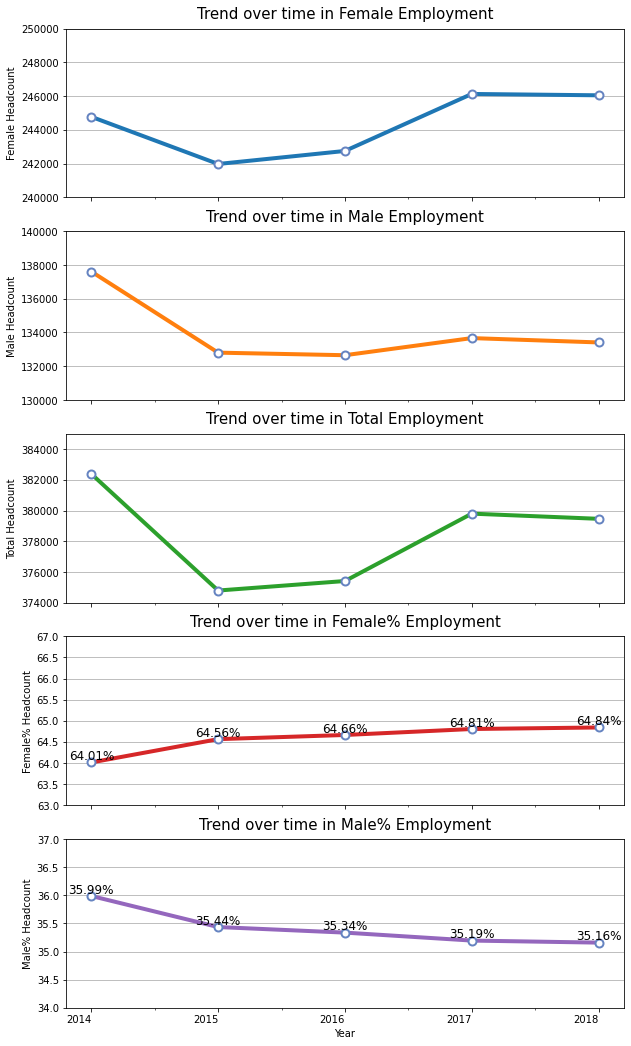

In [23]:
ax = wf_total.plot(subplots=True, figsize=(10,20), linewidth=4, alpha=1, marker='o', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2,legend=False, rot=0)


for i, a in enumerate(ax):
  a.yaxis.grid(True)
  a.set_xticks(list(wf_total.index))
  a.set_ylabel("{} Headcount".format(wf_total.columns[i]))
  a.set_xlabel("Year")
  a.set_title("Trend over time in {} Employment".format(wf_total.columns[i]), fontdict={'size':15}, pad=10)
  if i in (3,4):
    for j, txt in enumerate(wf_total.iloc[:,i]):
      a.annotate("{:.2f}%".format(txt), (wf_total.index[j], wf_total.iloc[j,i]), ha='center', va='bottom', fontsize=12)


ax[0].set_ylim([240000,250000])
ax[1].set_ylim([130000,140000])  
ax[2].set_ylim([374000,385000])
ax[3].set_ylim([63,67])
ax[4].set_ylim([34,37])

### Current Representation of Part-Time Employees


#### In the Sector

In [24]:
wf_pt = wf_data.loc[93,2018].unstack(level=0).loc[['Female'],:]
wf_pt.loc[1,:] = wf_pt.apply(lambda r: r/r.sum()*100, axis=1).squeeze()
wf_pt.rename(index={1:"Employee"}, inplace=True)

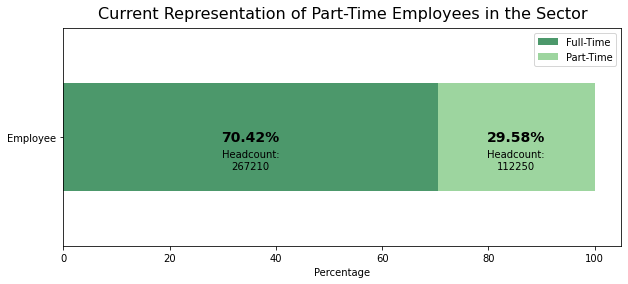

In [25]:
c = ["#006D2C","#74C476"]
ax = wf_pt.loc[['Employee'],:].plot.barh(stacked=True, color=c, alpha=0.7, figsize=(10,4))
ax.set_title("Current Representation of Part-Time Employees in the Sector", fontdict={'size':16}, pad=10)
ax.set_xlabel("Percentage")
for i, p in enumerate(ax.patches):
  width, height = p.get_width(), p.get_height()
  x, y = p.get_xy() 
  ax.annotate('{:.2f}%'.format(width), (x + width/2, y + height/2), ha="center", va="center",fontsize=14, fontweight='bold')
  ax.annotate('Headcount:\n{}'.format(int(wf_pt.iloc[0,i])), (x + width/2, y + height/3.5), ha="center", va="center")

#### In each Cluster

In [26]:
wf_curr = wf_data[['',2018]].groupby([('', '', 'Cluster')]).sum()
wf_curr = wf_curr.groupby(level=[1], axis=1).sum()
wf_curr.sort_values(by=['Part-Time'], ascending=False, inplace=True)
wf_curr[['Full-Time%','Part-Time%']] = wf_curr.apply(lambda r: r/r.sum()*100, axis=1)

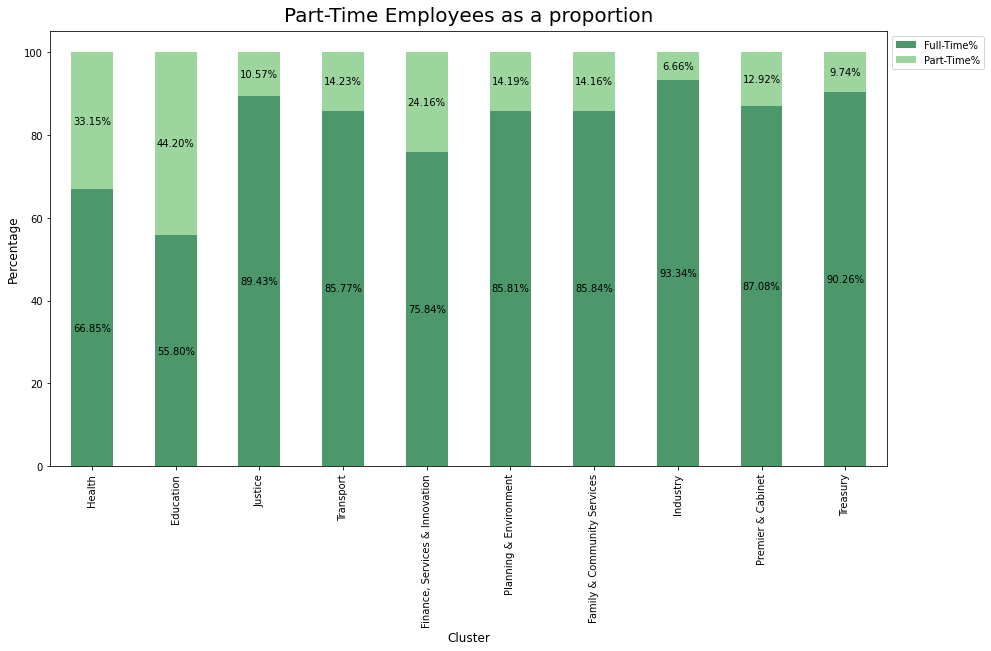

In [27]:
c = ["#006D2C","#74C476"]
ax = wf_curr.iloc[:,2:].plot.bar(stacked=True, color=c, alpha=0.7, figsize=(15,8))
ax.set_ylabel("Percentage", fontdict={'size':12})
ax.set_xlabel("Cluster",fontdict={'size':12})
ax.set_title("Part-Time Employees as a proportion", fontdict={'size':20}, pad=10)
for p in ax.patches:
  width, height = p.get_width(), p.get_height()
  x, y = p.get_xy() 
  ax.annotate('{:.2f}%'.format(height), (x + 0.25, y + height/2),ha="center", va="center")
ax.legend(bbox_to_anchor=(1, 1))


##### TreeMap

(0.0, 100.0, 0.0, 100.0)

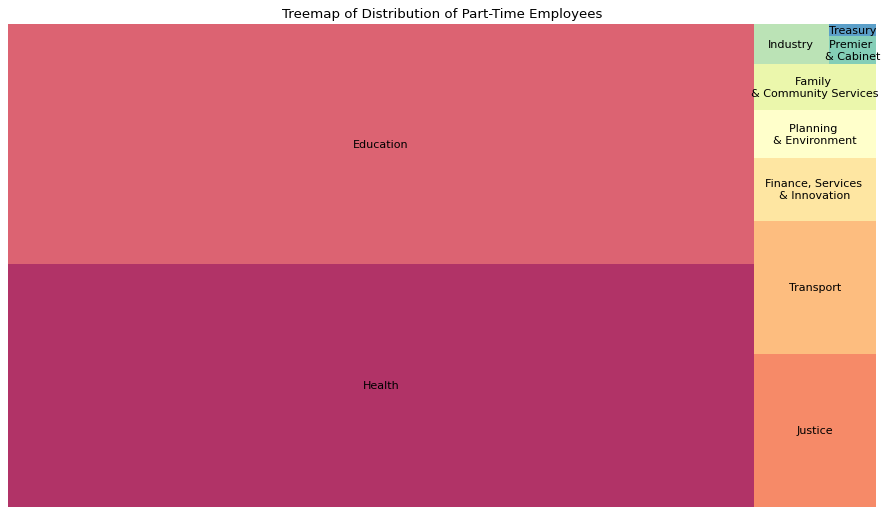

In [28]:
labels = [w.replace('&', '\n&') for w in wf_curr.index]
sizes = wf_curr['Part-Time'].tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(14,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Treemap of Distribution of Part-Time Employees')
plt.axis('off')

### Changes in Current Representation of Part-Time Employees over last 4 years 👷‍♂️

In [ ]:
wf_cluster = wf_data.groupby([('', '', 'Cluster')]).sum()

wf_cl_yr = wf_cluster.T.groupby(level=[0,1]).sum().xs('Part-Time', level=1)
wf_cl_yr1 = wf_cl_yr[['Health','Education']]
wf_cl_yr2 = wf_cl_yr.drop(columns=['Health','Education'])
ax=[None]*2
for i, df in enumerate([wf_cl_yr1, wf_cl_yr2]):
  ax[i] = df.plot(figsize=(10,10), xticks=df.index.tolist(), linewidth=4, alpha=1, marker='o', markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=1)

for a in ax:
  a.yaxis.grid(True)
  a.legend(title="Cluster")
  a.set_xlabel("Year")
  a.set_ylabel("Part-Headcount")

ax[0].set_title("Changes over the years for Part-Time Employees for each Cluster", fontdict={'size':16}, pad= 10)




ayy = wf_cluster.groupby(level=[0,1], axis=1).sum().T.unstack(level=1)
for col in ayy.columns.levels[0]:
  ayy.loc[:,col] = ayy[[col]].div(ayy[[col]].sum(axis=1), axis=0)

### Current Representation of Male and Female Part-Time Employees as a proportion of the respective Male and Female Workforce

#### In the Sector

In [ ]:
wf_prop_sec = wf_data.loc[[92],2018].groupby(level=[1,0], axis=1).sum().reset_index(drop=True)
for col in wf_prop_sec.columns.levels[0]:
  wf_prop_sec.loc[1,col] = wf_prop_sec.loc[[0],col].apply(lambda r: r/r.sum()*100, axis=1).squeeze().tolist()

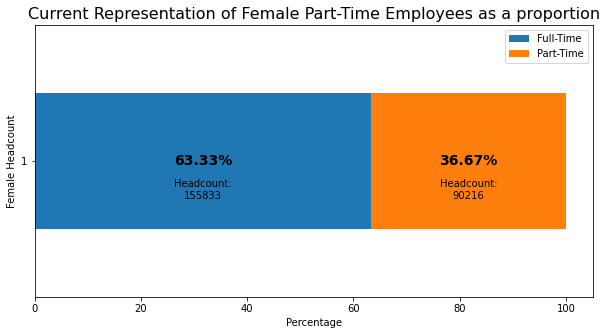

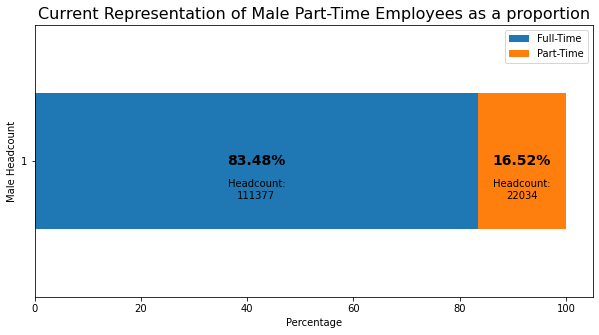

In [249]:
ax = [None]*2
for i, gen in enumerate(wf_prop_sec.columns.levels[0]):
  ax[i] = wf_prop_sec.loc[[1],gen].plot.barh(stacked=True, figsize=(10,5))
  ax[i].set_title("Current Representation of {} Part-Time Employees as a proportion".format(gen), fontdict={'size':16})
  ax[i].set_ylabel("{} Headcount".format(gen))
  ax[i].set_xlabel("Percentage")
  for j, p in enumerate(ax[i].patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax[i].annotate('{:.2f}%'.format(width), (x + width/2, y + height/2), ha="center", va="center",fontsize=14, fontweight='bold')
    ax[i].annotate('Headcount:\n{}'.format(int(wf_prop_sec.loc[[0],gen].iloc[:,j].values)), (x + width/2, y + height/3.5), ha="center", va="center")

#### In each Cluster

In [ ]:
wf_prop = wf_cluster.groupby(level=[2,1], axis=1).sum()
for col in wf_prop.columns.levels[0]:
  wf_prop.loc[:,col] = wf_prop[col].apply(lambda r: r/r.sum()*100, axis=1).values

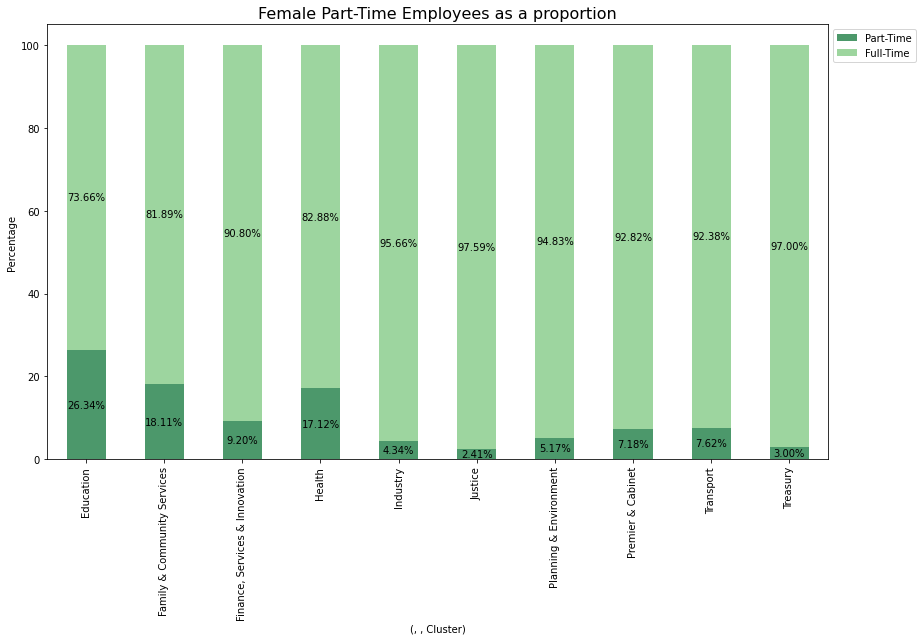

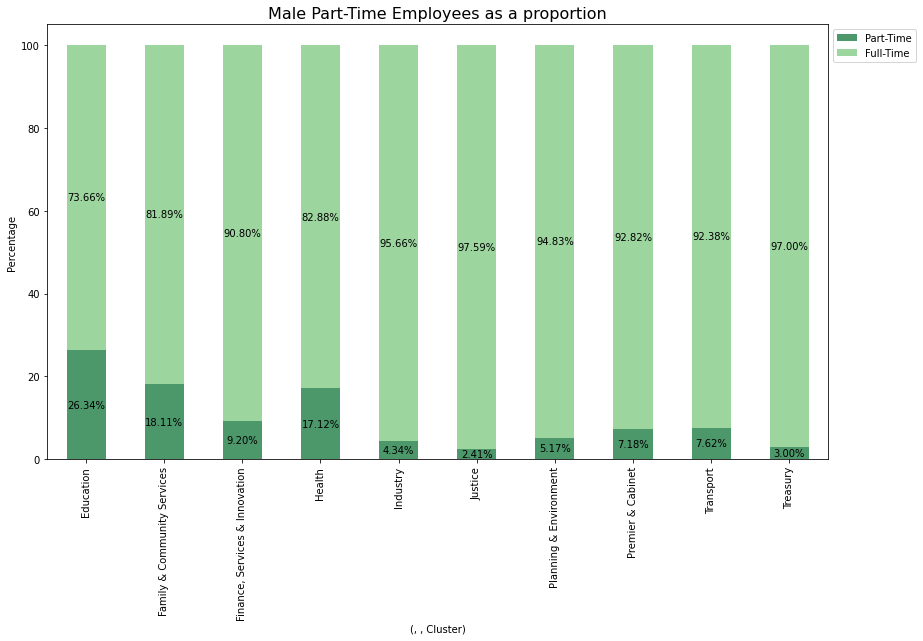

In [312]:
c = ["#006D2C","#74C476"]

ax = [None]*2
for i, gen in enumerate(list(wf_prop.columns.levels[0])):
  ax[i] = wf_prop[col][['Part-Time','Full-Time']].plot.bar(stacked=True, color=c, alpha=0.7, ax=ax[i], legend=False, figsize=(14,8))
  ax[i].set_title("{} Part-Time Employees as a proportion".format(gen), fontdict={'size':16})
  ax[i].set_ylabel("Percentage")
  ax[i].set_xlabel("Cluster")
  for p in ax[i].patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax[i].annotate('{:.2f}%'.format(height), (x + 0.25, y + height/2), ha="center", va="center")
  ax[i].legend(bbox_to_anchor=(1, 1))


### Changes in Current Representation of Male and Female Part-Time Employees as a proportion over last 4 years 👷‍♂️



In [321]:
wf_prop_yr = pd.DataFrame(columns=wf_cluster.columns, index=wf_cluster.index)
for year in list(wf_cluster.columns.levels[0])[:-1]:
  for emp in list(wf_cluster.columns.levels[1])[1:]:
    wf_prop_yr[year,emp] = wf_cluster[year,emp]/(wf_cluster[year,'Part-Time']+wf_cluster[year,'Full-Time'])
wf_prop_yr*=100

wf_prop_yr = wf_prop_yr.T.unstack(level=[2,1]).groupby(level=[1,0,2], axis=1).sum()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


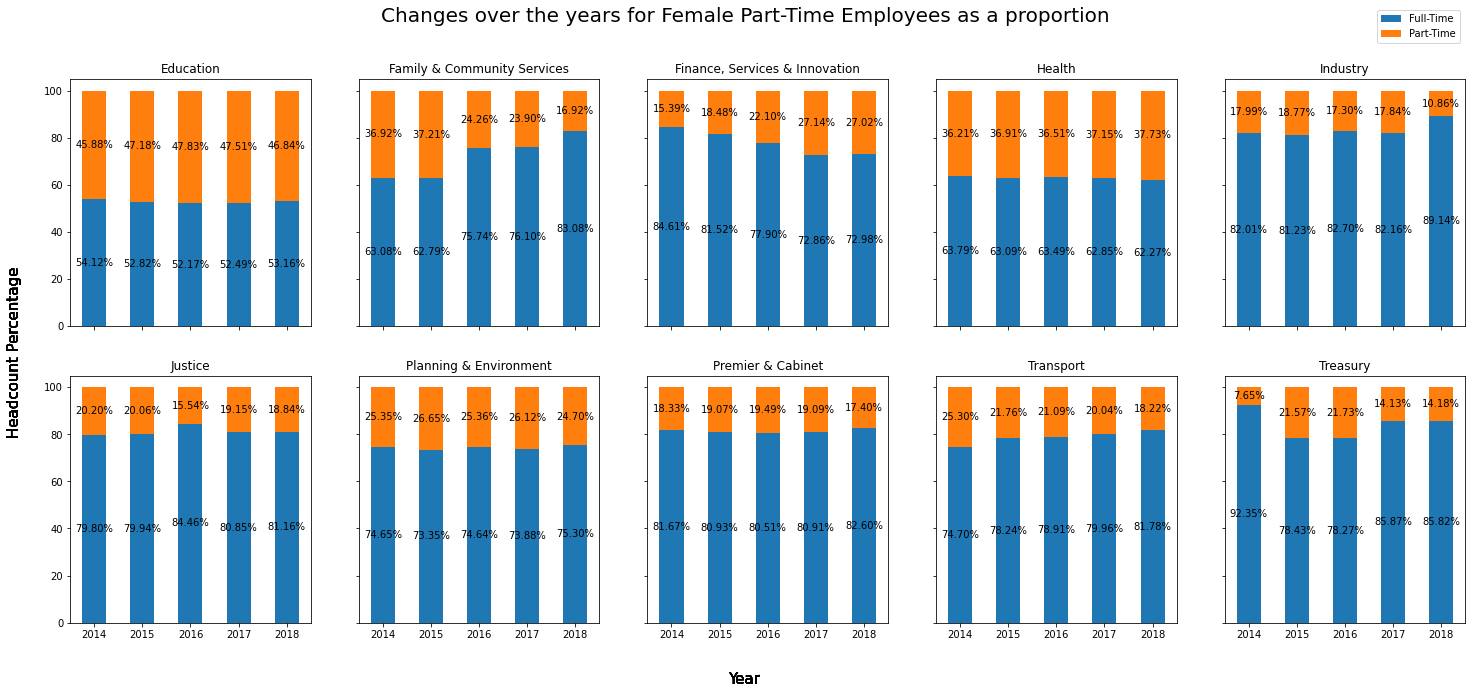

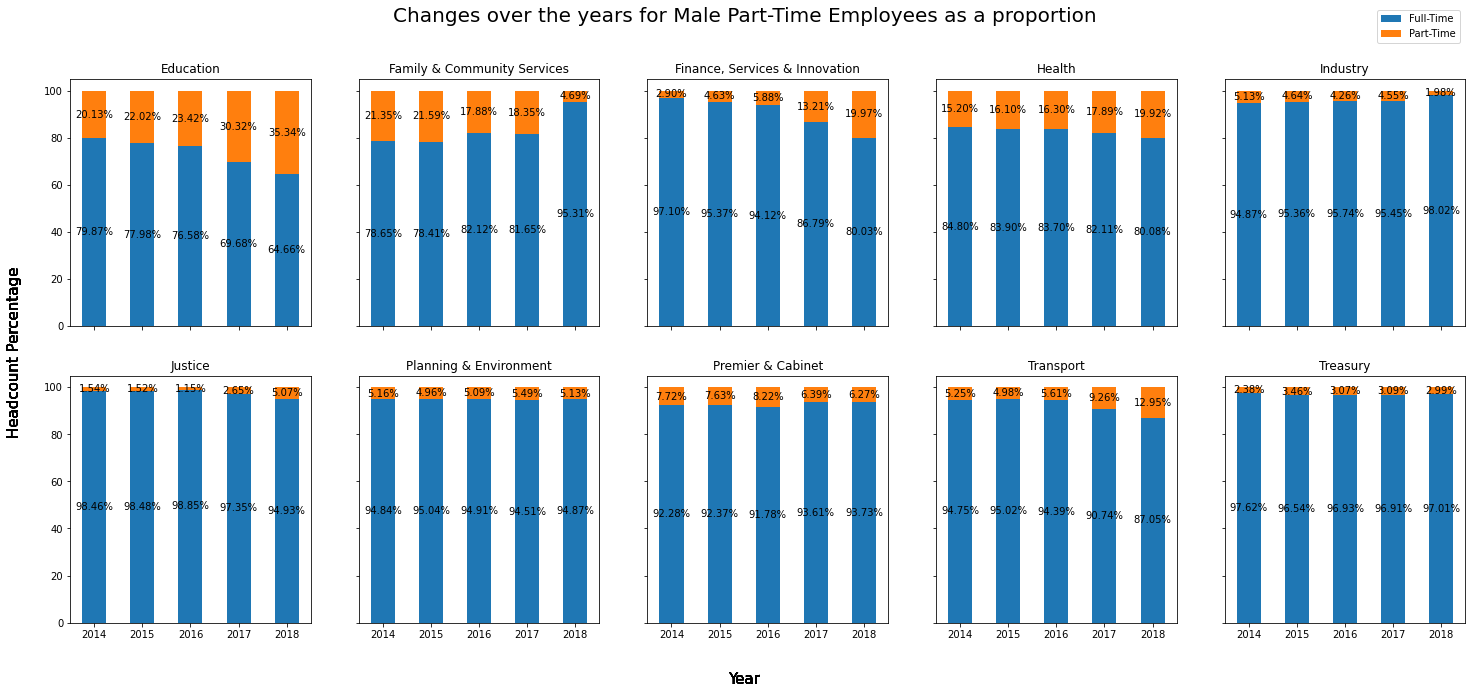

In [322]:
for i, gen in enumerate(list(wf_prop_yr.columns.levels[0])):
  fig, ax = plt.subplots(2,5, figsize=(25,10),sharex=True, sharey=True)
  ax = ax.flatten()
  fig.suptitle("Changes over the years for {} Part-Time Employees as a proportion".format(gen), fontsize=20)
  for j, cluster in enumerate(list(wf_prop_yr.columns.levels[1])):
    wf_prop_yr[gen][cluster].plot.bar(stacked=True, ax=ax[j], legend=False, title=cluster, rot=0)
    for p in ax[j].patches:
      width, height = p.get_width(), p.get_height()
      x, y = p.get_xy() 
      ax[j].annotate('{:.2f}%'.format(height), (x + 0.25, y + height/2),ha="center", va="center")
    ax[4].legend(bbox_to_anchor=(1, 1.3))
    fig.text(0.5, 0.04, 'Year', ha='center', fontdict={'size':15})
    fig.text(0.09, 0.5, 'Headcount Percentage', va='center', rotation='vertical',fontdict={'size':15})

### Projection of what the representation will be by 2025

In [ ]:
df = wf_total.groupby(level=[0,2]).sum().unstack(level=1).reset_index()
df.columns = [' '.join(col).strip() for col in df.columns.values]
df.Year = pd.to_datetime(df.Year, format='%Y')
df_male = df[['Total Male','Year']].rename(columns={'Year': "ds", 'Total Male':'y'})
df_female = df[['Total Female','Year']].rename(columns={'Year': "ds", 'Total Female':'y'})

In [ ]:
gm_male = fbprophet.Prophet(changepoint_prior_scale=0.5)
gm_female = fbprophet.Prophet(changepoint_prior_scale=0.5)

gm_male.fit(df_male)
gm_female.fit(df_female)

gm_forecast = gm_male.make_future_dataframe(periods=7, freq='Y')

gm_forecast_m = gm_male.predict(gm_forecast)
gm_forecast_f = gm_female.predict(gm_forecast)

In [ ]:
gm_prophet.plot(gm_forecast_m)

In [ ]:
gm_prophet.plot(gm_forecast_f)

## Task 2

Please prepare a discussion paper (maximum 4 A4 pages of content or 6 presentation slides) of your analysis that would be suitable for a Director to use as a discussion aid in a meeting with senior executives. You must include tables or charts that illustrate your findings.